In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import xarray as xr
import datetime
import timeit

from power_curve import Lkl_array, create_lkl_from_xls, create_lkl_from_1D_data


# QUICK SOLUTION

I build a single function `create_lkl_from_xls()` to handle the entire xls to netCDF transfer.

This Function will:

1. take all Leistungskennlinien inside the passed `.xls` file and structure them inside a `xarray.Dataarray`
2. interpolate them to the increment size of the Windatlas data,
3. extend the lkl's Windspeed to 0,
4. export the collection of lkl-Arrays to a netCDF-File

In [2]:
create_lkl_from_xls(
    xls_path = "/home/eouser/Documents/code/Windatlas/windatlas/anemos_data/wea_data/example/WEA_beispiel.xls",
    output_path = "/home/eouser/Documents/code/Windatlas/windatlas/anemos_data/wea_data/data/wea_lkl.nc",
)

# Step by Step 
## Load example Data

first loading `.xls` with all new *Leistungskennlinien* to `pandas` 

In [2]:
xls = pd.ExcelFile("/home/eouser/Documents/code/Windatlas/windatlas/anemos_data/wea_data/example/WEA_beispiel.xls", engine="xlrd")
xls.sheet_names

['WEA_beispiel', 'Enercon_E-48', 'Enercon_E-147']

In [3]:
lkl_dict = dict()

for sheet in xls.sheet_names:
    lkl_dict[sheet] = pd.read_excel(xls, sheet, index_col=0)

for key in lkl_dict:
    if key == 'WEA_beispiel':
        continue
    lkl_dict[key] = create_lkl_from_1D_data(base_lkl=lkl_dict['WEA_beispiel'], target_lkl=lkl_dict[key])

lkl_dict[key]

,0.950,0.975,1.000,1.025,1.050,1.075,1.100,1.125,1.150,1.175,1.200,1.225,1.250,1.275
3.0,48.0,51.0,53.0,56.0,58.0,61.0,64.0,66.0,68.0,71.0,74.0,76.0,79.0,82.0
3.5,109.0,112.0,117.0,120.0,125.0,128.0,133.0,136.0,141.0,144.0,148.0,152.0,156.0,160.0
4.0,189.0,196.0,202.0,208.0,215.0,220.0,226.0,233.0,239.0,245.0,251.0,257.0,263.0,270.0
4.5,293.0,302.0,311.0,320.0,329.0,338.0,347.0,356.0,364.0,373.0,383.0,391.0,400.0,409.0
5.0,422.0,434.0,446.0,459.0,471.0,483.0,495.0,508.0,520.0,533.0,545.0,557.0,569.0,581.0
5.5,577.0,593.0,610.0,627.0,643.0,660.0,676.0,692.0,709.0,725.0,742.0,758.0,775.0,791.0
6.0,763.0,784.0,805.0,827.0,849.0,869.0,891.0,913.0,934.0,955.0,976.0,997.0,1019.0,1040.0
6.5,980.0,1007.0,1034.0,1060.0,1088.0,1115.0,1142.0,1169.0,1195.0,1223.0,1249.0,1276.0,1302.0,1329.0
7.0,1228.0,1262.0,1296.0,1329.0,1363.0,1395.0,1429.0,1462.0,1495.0,1529.0,1561.0,1594.0,1627.0,1659.0
7.5,1509.0,1549.0,1590.0,1630.0,1671.0,1711.0,1751.0,1790.0,1830.0,1869.0,1908.0,1948.0,1987.0,2026.0


## Transforming the *Leistungskennlinie* to a *Windatlas* compatible format by building a `xarray` from `pandas` 

In [4]:
for key in lkl_dict:
    data_vars={'leistung':(['wspd','rho'], np.array(lkl_dict[key]), 
                            {'units': 'kWh',
                            'long_name':'Leistung aus Wind und Luftdichte'})}

    coords = {
            "wspd": (["wspd"], np.array(lkl_dict[key].index, dtype="float64")),
            "rho": (["rho"], np.array(lkl_dict[key].columns, dtype="float64")),
            }

    attrs = {#'wea_type':key,
            'describtion':"interpolated Leistungskennlinie",
            'creation_date':str(datetime.date.today()), 
            'author':'Claudius Wehner'}

    lkl_dict[key] = xr.DataArray(
        data=np.array(lkl_dict[key]),
        coords=coords,
        attrs=attrs
    )

lkl_dict[key]

<xarray.DataArray (wspd: 44, rho: 14)>
array([[  48.,   51.,   53.,   56.,   58.,   61.,   64.,   66.,   68.,
          71.,   74.,   76.,   79.,   82.],
       [ 109.,  112.,  117.,  120.,  125.,  128.,  133.,  136.,  141.,
         144.,  148.,  152.,  156.,  160.],
       [ 189.,  196.,  202.,  208.,  215.,  220.,  226.,  233.,  239.,
         245.,  251.,  257.,  263.,  270.],
       [ 293.,  302.,  311.,  320.,  329.,  338.,  347.,  356.,  364.,
         373.,  383.,  391.,  400.,  409.],
       [ 422.,  434.,  446.,  459.,  471.,  483.,  495.,  508.,  520.,
         533.,  545.,  557.,  569.,  581.],
       [ 577.,  593.,  610.,  627.,  643.,  660.,  676.,  692.,  709.,
         725.,  742.,  758.,  775.,  791.],
       [ 763.,  784.,  805.,  827.,  849.,  869.,  891.,  913.,  934.,
         955.,  976.,  997., 1019., 1040.],
       [ 980., 1007., 1034., 1060., 1088., 1115., 1142., 1169., 1195.,
        1223., 1249., 1276., 1302., 1329.],
       [1228., 1262., 1296., 1329., 1363., 1395., 1429., 1462., 1495.,
        1529., 1561., 1594., 1627., 1659.],
       [1509., 1549., 1590., 1630., 1671., 1711., 1751., 1790., 1830.,
        1869., 1908., 1948., 1987., 2026.],
...
       [5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000., 5000., 5000., 5000., 5000.],
       [5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000., 5000., 5000., 5000., 5000.],
       [5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000., 5000., 5000., 5000., 5000.],
       [5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000., 5000., 5000., 5000., 5000.],
       [5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000., 5000., 5000., 5000., 4998.],
       [5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000., 5000., 5000., 5000., 5000.],
       [5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000., 5000., 5000., 5000., 5000.],
       [5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000., 5000., 5000., 5000., 5000.],
       [5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000., 5000., 5000., 5000., 5000.],
       [5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000., 5000., 5000., 5000., 5000.]])
Coordinates:
  * wspd     (wspd) float64 3.0 3.5 4.0 4.5 5.0 5.5 ... 22.5 23.0 23.5 24.0 24.5
  * rho      (rho) float64 0.95 0.975 1.0 1.025 1.05 ... 1.2 1.225 1.25 1.275
Attributes:
    describtion:    interpolated Leistungskennlinie
    creation_date:  2022-03-10
    author:         Claudius Wehner

## Interpolation

Interpolation is done using the scipy.interpolation package for both 1D and 2D interpolation of wind turbine power delivery data.
Examples for the here used methods can be found online:
https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html#d-spline-representation-object-oriented-bivariatespline

### Example with plots for one lkl

Text(0.5, 1.0, 'Interpolated Leistungskennlinie')

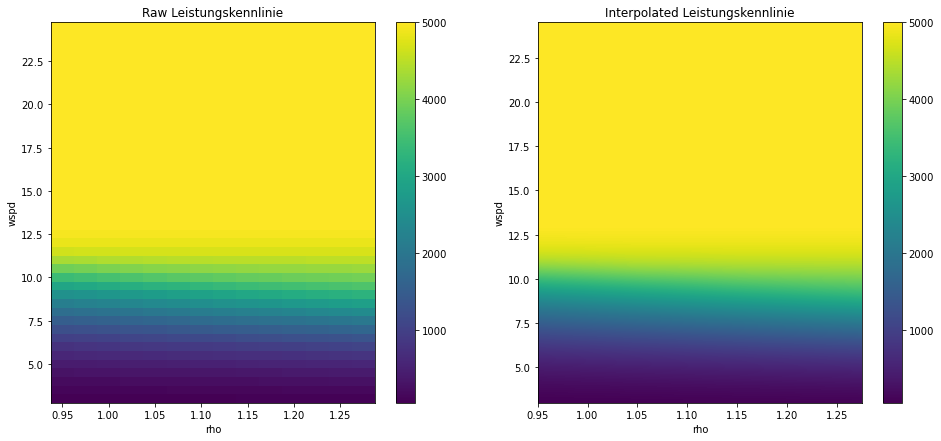

In [5]:
import matplotlib.pyplot as plt

increment_wspd = 0.001
increment_rho = 0.0001
power_limiter = True

fig, axes = plt.subplots(ncols=2, figsize=(16, 7))
lkl_dict[key].plot(ax=axes[0])
axes[0].set_title("Raw Leistungskennlinie")

new_wspd = np.arange(lkl_dict[key].wspd[0], lkl_dict[key].wspd[-1]+increment_wspd, increment_wspd, dtype=np.float64)
new_rho = np.arange(lkl_dict[key].rho[0], lkl_dict[key].rho[-1]+increment_rho, increment_rho, dtype=np.float64)
testarray2Di = lkl_dict[key].interp(wspd=new_wspd, rho=new_rho, method="cubic")

#### GOLDEN STEP TO MAKE .sel() WORK AFTER INTERPOLATION ####
# Reassigning helps solving the rounding error
testarray2Di = testarray2Di.assign_coords(
            coords={
                "wspd": testarray2Di.wspd.round(decimals=3),
                "rho": testarray2Di.rho.round(decimals=4)}
        )
#############################################################
if power_limiter:
    maxOriginalPower = lkl_dict[key].max()
    testarray2Di = testarray2Di.where(testarray2Di < maxOriginalPower, other = maxOriginalPower)
    testarray2Di = testarray2Di.where(testarray2Di > 0, other = 0)


testarray2Di.plot(ax=axes[1])
axes[1].set_title("Interpolated Leistungskennlinie")

### Interpolating all arrays in lkl_dict

In [6]:
increment_wspd = 0.001
increment_rho = 0.0001
power_limiter = True

for key in lkl_dict:
    new_wspd = np.arange(lkl_dict[key].wspd[0], lkl_dict[key].wspd[-1]+increment_wspd, increment_wspd, dtype=np.float64)
    new_rho = np.arange(lkl_dict[key].rho[0], lkl_dict[key].rho[-1]+increment_rho, increment_rho, dtype=np.float64)
    testarray2Di = lkl_dict[key].interp(wspd=new_wspd, rho=new_rho, method="cubic")

    #### GOLDEN STEP TO MAKE .sel() WORK AFTER INTERPOLATION ####
    # Reassigning helps solving the rounding error
    testarray2Di = testarray2Di.assign_coords(
                coords={
                    "wspd": testarray2Di.wspd.round(decimals=3),
                    "rho": testarray2Di.rho.round(decimals=4)}
            )
    #############################################################
    if power_limiter:
        maxOriginalPower = lkl_dict[key].max()
        testarray2Di = testarray2Di.where(testarray2Di < maxOriginalPower, other = maxOriginalPower)
        testarray2Di = testarray2Di.where(testarray2Di > 0, other = 0)
    
    lkl_dict[key] = testarray2Di

### Example Plot for Power Limiter

Text(0.5, 1.0, 'Cut interpolated Leistungskennlinie')

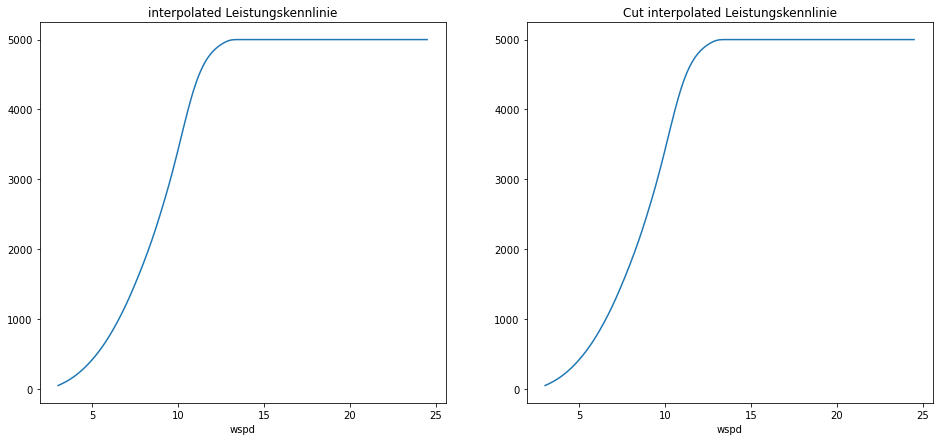

In [11]:
maxOriginalPower = lkl_dict[key].max()
 
fig, axes = plt.subplots(ncols=2, figsize=(16, 7))
testarray2Di.isel(rho=7).plot(ax=axes[0])
axes[0].set_title("interpolated Leistungskennlinie")

test = testarray2Di.where(testarray2Di < maxOriginalPower, other = maxOriginalPower)

test.isel(rho=7).plot(ax=axes[1])
axes[1].set_title("Cut interpolated Leistungskennlinie")

In [7]:
lkl_dict[key]

<xarray.DataArray (wspd: 21501, rho: 3251)>
array([[  48.        ,   48.01851687,   48.03696332, ...,   81.98129467,
          81.99066335,   82.        ],
       [  48.10700671,   48.12535727,   48.14363878, ...,   82.10226663,
          82.11160983,   82.12092087],
       [  48.21406557,   48.23225049,   48.25036772, ...,   82.22338504,
          82.23270297,   82.24198861],
       ...,
       [5000.        , 5000.        , 5000.        , ..., 4999.99951564,
        4999.99951188, 4999.99950811],
       [5000.        , 5000.        , 5000.        , ..., 4999.99975709,
        4999.99975521, 4999.99975331],
       [5000.        , 5000.        , 5000.        , ..., 5000.        ,
        5000.        , 5000.        ]])
Coordinates:
  * wspd     (wspd) float64 3.0 3.001 3.002 3.003 3.004 ... 24.5 24.5 24.5 24.5
  * rho      (rho) float64 0.95 0.9501 0.9502 0.9503 ... 1.275 1.275 1.275 1.275
Attributes:
    describtion:    interpolated Leistungskennlinie
    creation_date:  2022-03-10
    author:         Claudius Wehner

## Concatination and Export

In [8]:
concatinated = xr.concat(lkl_dict.values(), pd.Index(lkl_dict.keys(), name="wea_type"))
concatinated.sel(wea_type="WEA_beispiel")

<xarray.DataArray (wspd: 21501, rho: 3251)>
array([[  51.        ,   51.01270992,   51.0254113 , ...,   86.98139803,
          86.99071534,   87.        ],
       [  51.13315304,   51.1458183 ,   51.15847544, ...,   87.14696298,
          87.15623177,   87.16546745],
       [  51.26634131,   51.2789621 ,   51.2915752 , ...,   87.31261488,
          87.32183541,   87.33102238],
       ...,
       [1116.45999742, 1116.45999742, 1116.45999742, ..., 1116.45975524,
        1116.45975336, 1116.45975147],
       [1116.22976145, 1116.22976145, 1116.22976145, ..., 1116.22964   ,
        1116.22963906, 1116.22963811],
       [1116.        , 1116.        , 1116.        , ..., 1116.        ,
        1116.        , 1116.        ]])
Coordinates:
  * wspd      (wspd) float64 3.0 3.001 3.002 3.003 3.004 ... 24.5 24.5 24.5 24.5
  * rho       (rho) float64 0.95 0.9501 0.9502 0.9503 ... 1.275 1.275 1.275
    wea_type  <U12 'WEA_beispiel'
Attributes:
    describtion:    interpolated Leistungskennlinie
    creation_date:  2022-03-10
    author:         Claudius Wehner

In [11]:
#concatinated.to_netcdf(path = "data/wea_lkl.nc", mode="w")

# Test calculation of power output

In [10]:
size = 525888

wspd = np.around(np.random.uniform(float(test.wspd.min()), float(test.wspd.max()), size=size),1)#.astype(np.float64)
rho = np.around(np.random.uniform(float(test.rho.min()), float(test.rho.max()), size=size),3)#.astype(np.float64)
start = timeit.default_timer()
#### GOLDEN STEP ####
dummy = concatinated.sel(wea_type="WEA_beispiel").load().sel(
    wspd=xr.DataArray(wspd, dims='wea'), 
    rho=xr.DataArray(rho, dims='wea'), 
    method="nearest")# if error appears, use method="nearest"
#####################
end = timeit.default_timer()
timed = end - start
del(wspd)
del(rho)
print(f'Time to get {size} "leistungs"-values from equivalent wspd and rho time series data: {timed}')
concatinated#.to_numpy()/ 6 #[:100]

Time to get 525888 "leistungs"-values from equivalent wspd and rho time series data: 0.07865351624786854


<xarray.DataArray (wea_type: 3, wspd: 21501, rho: 3251)>
array([[[5.10000000e+01, 5.10127099e+01, 5.10254113e+01, ...,
         8.69813980e+01, 8.69907153e+01, 8.70000000e+01],
        [5.11331530e+01, 5.11458183e+01, 5.11584754e+01, ...,
         8.71469630e+01, 8.71562318e+01, 8.71654675e+01],
        [5.12663413e+01, 5.12789621e+01, 5.12915752e+01, ...,
         8.73126149e+01, 8.73218354e+01, 8.73310224e+01],
        ...,
        [1.11646000e+03, 1.11646000e+03, 1.11646000e+03, ...,
         1.11645976e+03, 1.11645975e+03, 1.11645975e+03],
        [1.11622976e+03, 1.11622976e+03, 1.11622976e+03, ...,
         1.11622964e+03, 1.11622964e+03, 1.11622964e+03],
        [1.11600000e+03, 1.11600000e+03, 1.11600000e+03, ...,
         1.11600000e+03, 1.11600000e+03, 1.11600000e+03]],

       [[3.00000000e+00, 2.99419305e+00, 2.98844797e+00, ...,
         5.00010336e+00, 5.00005199e+00, 5.00000000e+00],
        [3.01072722e+00, 3.00498742e+00, 2.99930893e+00, ...,
         5.01718695e+00, 5.01719723e+00, 5.01720718e+00],
        [3.02145611e+00, 3.01578324e+00, 3.01017113e+00, ...,
         5.03426982e+00, 5.03434151e+00, 5.03441315e+00],
...
        [8.10000000e+02, 8.10000000e+02, 8.10000000e+02, ...,
         8.10000000e+02, 8.10000000e+02, 8.10000000e+02],
        [8.10000000e+02, 8.10000000e+02, 8.10000000e+02, ...,
         8.10000000e+02, 8.10000000e+02, 8.10000000e+02],
        [8.10000000e+02, 8.10000000e+02, 8.10000000e+02, ...,
         8.10000000e+02, 8.10000000e+02, 8.10000000e+02]],

       [[4.80000000e+01, 4.80185169e+01, 4.80369633e+01, ...,
         8.19812947e+01, 8.19906633e+01, 8.20000000e+01],
        [4.81070067e+01, 4.81253573e+01, 4.81436388e+01, ...,
         8.21022666e+01, 8.21116098e+01, 8.21209209e+01],
        [4.82140656e+01, 4.82322505e+01, 4.82503677e+01, ...,
         8.22233850e+01, 8.22327030e+01, 8.22419886e+01],
        ...,
        [5.00000000e+03, 5.00000000e+03, 5.00000000e+03, ...,
         4.99999952e+03, 4.99999951e+03, 4.99999951e+03],
        [5.00000000e+03, 5.00000000e+03, 5.00000000e+03, ...,
         4.99999976e+03, 4.99999976e+03, 4.99999975e+03],
        [5.00000000e+03, 5.00000000e+03, 5.00000000e+03, ...,
         5.00000000e+03, 5.00000000e+03, 5.00000000e+03]]])
Coordinates:
  * wspd      (wspd) float64 3.0 3.001 3.002 3.003 3.004 ... 24.5 24.5 24.5 24.5
  * rho       (rho) float64 0.95 0.9501 0.9502 0.9503 ... 1.275 1.275 1.275
  * wea_type  (wea_type) object 'WEA_beispiel' 'Enercon_E-48' 'Enercon_E-147'
Attributes:
    describtion:    interpolated Leistungskennlinie
    creation_date:  2022-03-10
    author:         Claudius Wehner

In [17]:
path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.*.ts.nc"
data = xr.open_mfdataset(path, engine='h5netcdf', parallel=True)

start = str(2009)
end = str(2018)
data = data.sel(time=slice(start, end))

data.time.values

array(['2009-01-01T00:00:00.000000000', '2009-01-01T00:10:00.000000000',
       '2009-01-01T00:20:00.000000000', ...,
       '2018-12-31T23:30:00.000000000', '2018-12-31T23:40:00.000000000',
       '2018-12-31T23:50:00.000000000'], dtype='datetime64[ns]')

<AxesSubplot:>

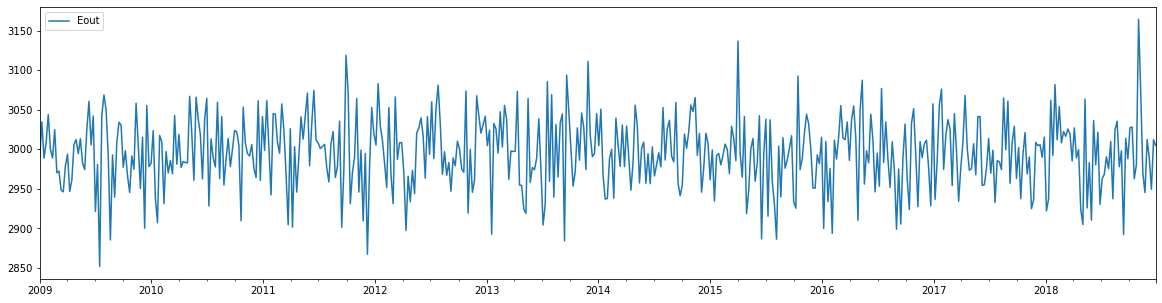

In [18]:
df = dummy.to_pandas().to_frame()
df = df.rename({0: "Eout"}, axis=1)
df = df.set_index(data.time.values)
#df["wspd"] = dummy.wspd.values
#df["rho"] = dummy.rho.values *10
#df.loc[:,"leistung"] = df["leistung"] /100
df.resample("7d").mean().plot(figsize=(20,5))

# OUTDATED! NOW SINGLE FUNCTION AT THE TOP OF THE NOTEBOOK
## Use of the Lkl_array class

In [ ]:
test_wea = Lkl_array(
    source_csv = 'example/WEA_beispiel.csv',  
)
test_wea.lkl_interpolate(
    increment_wspd=0.001,
    increment_rho = 0.0001,
)
path = "example/test_wea.nc"
test_wea.to_netcdf(path=path, name_if_dataarray="test_wea")

xr.open_dataset(path, engine='h5netcdf')